In [2]:
# basic libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling libs
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, roc_curve
import joblib  # to save models


In [3]:
df = pd.read_csv("../data/processed/cleaned_dataset.csv", low_memory=False)
df.shape, df.columns.tolist()
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618174 entries, 0 to 618173
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UnderwrittenCoverID       618174 non-null  int64  
 1   PolicyID                  618174 non-null  int64  
 2   TransactionMonth          618174 non-null  object 
 3   IsVATRegistered           618174 non-null  bool   
 4   Citizenship               618174 non-null  object 
 5   LegalType                 618174 non-null  object 
 6   Title                     618174 non-null  object 
 7   Language                  618174 non-null  object 
 8   Bank                      618174 non-null  object 
 9   AccountType               618174 non-null  object 
 10  MaritalStatus             618174 non-null  object 
 11  Gender                    618174 non-null  object 
 12  Country                   618174 non-null  object 
 13  Province                  618174 non-null  o

Define modeling cohorts & targets

We’ll build 3 models:

Severity model (regression): target TotalClaims on rows where HasClaim==1

Probability model (classification): target HasClaim (0/1) on full dataset

Premium model (optional): target TotalPremium or CalculatedPremiumPerTerm

In [4]:
# binary flag if not present
if 'HasClaim' not in df.columns:
    df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# basic margin
df['Margin'] = df['TotalPremium'] - df['TotalClaims']


In [5]:
df_sev = df[df['HasClaim'] == 1].copy()   # severity dataset
df_prob = df.copy()                       # probability dataset


In [6]:
len(df), len(df_sev), df['HasClaim'].mean()  # prevalence

(618174, 2641, 0.004272259913875381)

DATA PREPARATION 

Select Modeling Features

In [7]:
features = [
    'Province', 'VehicleType', 'make', 'Model', 'NewVehicle',
    'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors',
    'RegistrationYear', 'AlarmImmobiliser', 'TrackingDevice', 'CoverType'
]


In [8]:
# fill categorical nulls with 'Unknown'
cat_cols = [c for c in features if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')
    df_sev[c] = df_sev[c].fillna('Unknown')

# numeric fill with median
num_cols = [c for c in features if c not in cat_cols]
for c in num_cols:
    med = df[c].median()
    df[c] = df[c].fillna(med)
    df_sev[c] = df_sev[c].fillna(med)


Encoding

In [9]:
# Example for severity dataset:
X_sev = pd.get_dummies(df_sev[features], drop_first=True)
y_sev = df_sev['TotalClaims']

X_prob = pd.get_dummies(df[features], drop_first=True)
y_prob = df['HasClaim']


In [10]:
X_sev.shape, X_prob.shape

((2641, 187), (618174, 479))

Scaling

In [11]:
scaler = StandardScaler()
# if using linear models:
X_sev_scaled = scaler.fit_transform(X_sev)  # save scaler for deployment


Train/Test split & baseline (Severity model)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_sev, y_sev, test_size=0.2, random_state=42)


In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Linear Regression | RMSE:", rmse, " R2:", r2)


Linear Regression | RMSE: 12836348843245.611  R2: -1.6606257297583658e+17


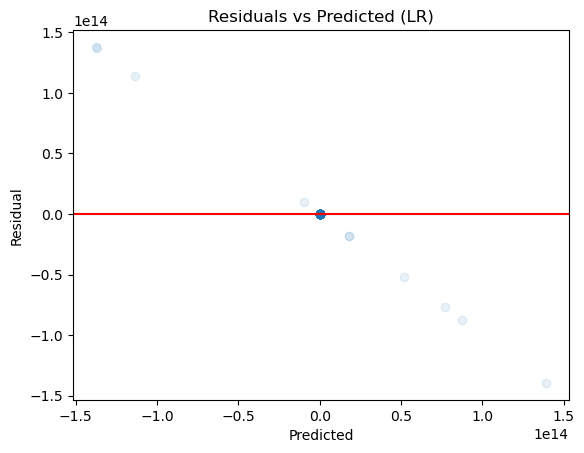

In [14]:
plt.scatter(y_pred, y_test - y_pred, alpha=0.1)
plt.axhline(0, color='r')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (LR)")
plt.show()


Stronger regressors (Severity): Random Forest & XGBoost

In [15]:
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_rf))
r2_rf = r2_score(y_test, y_rf)
print("RF RMSE:", rmse_rf, "R2:", r2_rf)


RF RMSE: 29773.307747050145 R2: 0.10660624281153419


Classification model (Claim Probability)

In [17]:
Xtr, Xte, ytr, yte = train_test_split(X_prob, y_prob, test_size=0.2, random_state=42, stratify=y_prob)
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(Xtr, ytr)
yhat = clf.predict(Xte)
yprob = clf.predict_proba(Xte)[:,1]

print(classification_report(yte, yhat))
print("ROC AUC:", roc_auc_score(yte, yprob))


              precision    recall  f1-score   support

           0       1.00      0.85      0.92    123107
           1       0.02      0.62      0.03       528

    accuracy                           0.85    123635
   macro avg       0.51      0.74      0.48    123635
weighted avg       0.99      0.85      0.92    123635

ROC AUC: 0.7648540328061497


Text(0.5, 1.0, 'ROC')

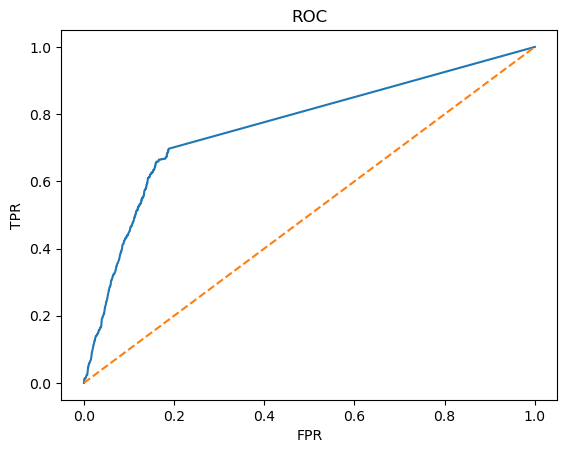

In [18]:
fpr, tpr, _ = roc_curve(yte, yprob)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC')


Feature importance & explainability

Text(0.5, 1.0, 'Top 20 RF feature importances')

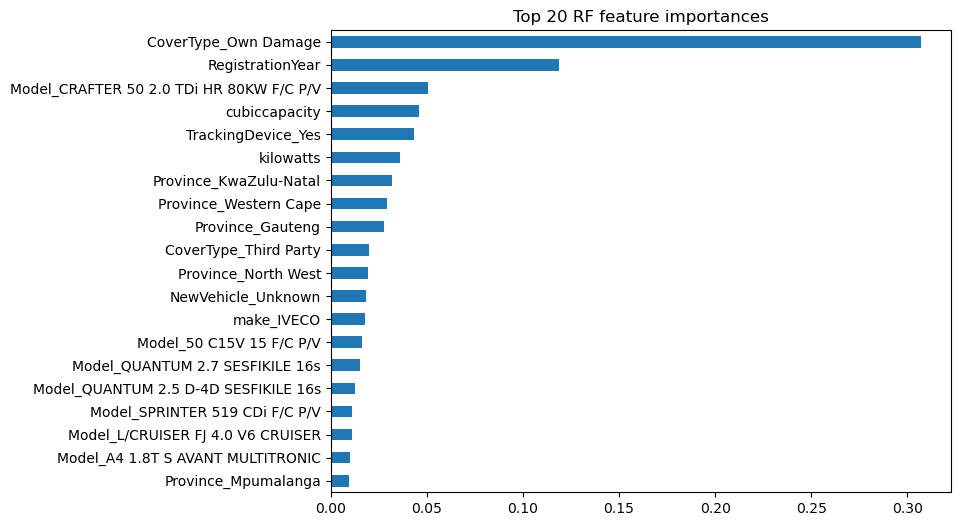

In [19]:
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
imp.plot(kind='barh', figsize=(8,6)); plt.gca().invert_yaxis(); plt.title('Top 20 RF feature importances')
